In [1]:
from toolbox_ziyan import *
import warnings
import random
import os
import pandas as pd
import numpy as np
import cv2
import librosa
import time
import re

import matplotlib.pyplot as plt
import numpy as np
from ConfigSpace import (
    Categorical,
    Configuration,
    ConfigurationSpace,
    EqualsCondition,
    Float,
    InCondition,
    Integer,
)
from sklearn.datasets import load_digits
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import cohen_kappa_score, accuracy_score

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from skopt.callbacks import DeadlineStopper

from smac import MultiFidelityFacade as MFFacade
from smac import Scenario
from smac.facade import AbstractFacade
from smac.intensifier.hyperband import Hyperband
from smac.intensifier.successive_halving import SuccessiveHalving

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim
import torchaudio
import torchaudio.transforms as trans


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)



In [2]:
class FSDKaggle18Dataset(Dataset):
    """
    This class is based on torch.utils.data.Dataset for loading the entire
    FSDKaggle18 Dataset using native torch and torchaudio primitives.

    ----------------------------------------------------
    Input parameters:
      annotations_file: str
      Path to the file containing the ground truths

      audio_dir: str
      Path to the folder containing the audio files

    Returns:
    instance of torch.utils.data.Dataset() returning the audio file together with it's corresponding label.

    """

    def __init__(self, annotations_file, audio_dir):
        # loop through the csv entries and only add entries from folders in the folder list
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        data_final = []
        for filepaths in os.listdir(self.audio_dir):
            data_final.append(os.path.join(self.audio_dir, filepaths))
        self.data_final = data_final

    def __getitem__(self, index):
        audio_sample_path = self._get_sample_path(index)
        label = self._get_label_(index)
        signal, sr = torchaudio.load(audio_sample_path)
        return signal, sr, label

    def _get_sample_path(self, index):
        return os.path.join(self.audio_dir, self.annotations.iloc[index, 0])

    def _get_label_(self, index1):
        labels_to_index = {
            "Acoustic_guitar": 0,
            "Applause": 1,
            "Bass_drum": 2,
            "Cello": 3,
            "Clarinet": 4,
            "Double_bass": 5,
            "Fart": 6,
            "Fireworks": 7,
            "Flute": 8,
            "Hi-hat": 9,
            "Laughter": 10,
            "Saxophone": 11,
            "Shatter": 12,
            "Snare_drum": 13,
            "Squeak": 14,
            "Tearing": 15,
            "Trumpet": 16,
            "Violin_or_fiddle": 17,
        }
        get_labels = self.annotations["label"].replace(labels_to_index).to_list()
        y_value = get_labels[index1]
        return y_value

    def __len__(self):
        return len(os.listdir(self.audio_dir))


def load_fsdk18(path_recordings, labels_file, label_arr, feature_type="spectrogram"):

    audio_data = []  # audio data
    x_audio = []  # STFT spectrogram
    x_audio_mini = []  # resized image, 32*32
    y_number = []  # label of number  # label of speaker
    if feature_type == "spectrogram":
        a = trans.Spectrogram(n_fft=128, normalized=True)
    elif feature_type == "melspectrogram":
        a = trans.MelSpectrogram(n_fft=128, normalized=True)
    elif feature_type == "mfcc":
        a = trans.MFCC(n_mfcc=128)
    for i in path_recordings:
        x, sr = librosa.load(i, sr=44100)
        i = i[-12:]
        x_stft_db = a(torch.tensor(x)).numpy()
        # Convert an amplitude spectrogram to dB-scaled spectrogram
        x_stft_db_mini = cv2.resize(x_stft_db, (32, 32))  # Resize into 32 by 32
        get_label_location = int(
            labels_file.fname.index[labels_file["fname"] == i].to_numpy()
        )

        y_n = label_arr[get_label_location]  # label number
        # Check if the label is in the labels_to_index dictionary
        if y_n in labels_to_index.values():
            audio_data.append(x)
            x_audio.append(x_stft_db)
            x_audio_mini.append(x_stft_db_mini)
            y_number.append(y_n)

    x_audio_mini = np.array(x_audio_mini)
    y_number = np.array(y_number).astype(int)

    return x_audio_mini, y_number

def combinations_45(iterable, r):
    """Extracts 45 combinations from given list"""
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    count = 0
    while count < 44:
        count += 1
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i + 1, r):
            indices[j] = indices[j - 1] + 1
        yield tuple(pool[i] for i in indices)

torch.multiprocessing.freeze_support()

# parser = argparse.ArgumentParser()
# parser.add_argument("-m", help="class number")
# parser.add_argument("-f", help="feature type")
# parser.add_argument("-data", help="audio files location")
# parser.add_argument("-labels", help="labels file location")
# args = parser.parse_args()
n_classes = 3 #int(args.m)
feature_type = 'spectrogram'#str(args.f)

train_folder = '/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/FSDKaggle2018.audio_data'#str(args.data)
train_label = pd.read_csv(str('/Users/whhqund/Desktop/JHU/NeuroData/df-dn-paper/benchmarks/audition/labels.csv'))#args.labels))

# select subset of data that only contains 300 samples per class
labels_chosen = train_label[
    train_label["label"].map(train_label["label"].value_counts() >= 0)
]

training_files = []
for file in os.listdir(train_folder):
    for x in labels_chosen.fname.to_list():
        if file.endswith(x):
            training_files.append(file)

path_recordings = []
for audiofile in training_files:
    path_recordings.append(os.path.join(train_folder, audiofile))

# convert selected label names to integers
labels_to_index = {
    "Acoustic_guitar": 0,
    "Applause": 1,
    "Bass_drum": 2,
    "Cello": 3,
    "Clarinet": 4,
    "Double_bass": 5,
    "Fart": 6,
    "Fireworks": 7,
    "Flute": 8,
    "Hi-hat": 9,
    "Laughter": 10,
    "Saxophone": 11,
    "Shatter": 12,
    "Snare_drum": 13,
    "Squeak": 14,
    "Tearing": 15,
    "Trumpet": 16,
    "Violin_or_fiddle": 17,
}

# encode labels to integers
get_labels = labels_chosen["label"].replace(labels_to_index).to_list()

 # data is normalized upon loading
# load dataset
x_spec, y_number = load_fsdk18(
    path_recordings, labels_chosen, get_labels, feature_type
)

nums = list(range(18))
samples_space = np.geomspace(10, 450, num=6, dtype=int)
# define path, samples space and number of class combinations
if feature_type == "melspectrogram":
    quit(0)
    prefix = args.m + "_class_mel/"
elif feature_type == "spectrogram":
    # prefix = args.m + "_class/"
    prefix = 'spectrogram' + '_class/'
elif feature_type == "mfcc":
    quit(0)
    prefix = args.m + "_class_mfcc/"

# create list of classes with const random seed
random.Random(5).shuffle(nums)
classes_space = list(combinations_45(nums, n_classes))

# scale the data
# x_spec = x_spec[:5400] #reshape x_spec by Ziyan for testing, orginial shape was (11073, 32, 32)
# print(x_spec.shape)
x_spec = scale(x_spec.reshape(len(x_spec), -1), axis=1).reshape(len(x_spec), 32, 32)
y_number = np.array(y_number)
# y_number = y_number[:5400] #reshape x_spec by Ziyan for testing, orginial shape was (11073, 32, 32)

# need to take train/valid/test equally from each class
trainx, remainx, trainy, remainy = train_test_split(
    x_spec,
    y_number,
    shuffle=True,
    test_size=0.5,
    stratify=y_number,
)

testx, valx, testy, valy = train_test_split(
    remainx,
    remainy,
    shuffle=True,
    test_size=0.5,
    stratify=remainy,
)

# 3000 samples, 80% train is 2400 samples, 20% test
fsdk18_train_images = trainx.reshape(-1, 32 * 32)
fsdk18_train_labels = trainy.copy()
# reshape in 2d array
fsdk18_test_images = testx.reshape(-1, 32 * 32)
fsdk18_test_labels = testy.copy()
# validation set
fsdk18_valid_images = valx.reshape(-1, 32 * 32)
fsdk18_valid_labels = valy.copy()

scaler = StandardScaler()
train_images = scaler.fit_transform(fsdk18_train_images)
valid_images = scaler.transform(fsdk18_valid_images)

train_images = torch.FloatTensor(train_images).unsqueeze(1)
train_labels = torch.LongTensor(fsdk18_train_labels)
valid_images = torch.FloatTensor(valid_images).unsqueeze(1)
valid_labels = torch.LongTensor(fsdk18_valid_labels)

train_x = train_images
train_y = train_labels
valid_x = valid_images
valid_y = valid_labels
# train_x_resnet = torch.cat((train_images, train_images, train_images), dim=1)
# valid_x_resnet = torch.cat((valid_images, valid_images, valid_images), dim=1)

In [43]:
print(train_x.shape)

torch.Size([3111, 1, 1024])


2024-03-12 15:02:15,284 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 261.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-12 15:02:15,284 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 261.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-12 15:02:15,288 - distributed.core - INFO - Event loop was unresponsive in Nanny for 261.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


In [3]:
def get_ece(predicted_posterior, predicted_label, true_label, num_bins=40):
    """
    Return expected calibration error (ECE)
    """
    poba_hist = []
    accuracy_hist = []
    bin_size = 1 / num_bins
    total_sample = len(true_label)
    posteriors = predicted_posterior.max(axis=1)

    score = 0
    for bin in range(num_bins):
        indx = np.where(
            (posteriors > bin * bin_size) & (posteriors <= (bin + 1) * bin_size)
        )[0]

        acc = (
            np.nan_to_num(np.mean(predicted_label[indx] == true_label[indx]))
            if indx.size != 0
            else 0
        )
        conf = np.nan_to_num(np.mean(posteriors[indx])) if indx.size != 0 else 0
        score += len(indx) * np.abs(acc - conf)

    score /= total_sample
    return score

In [4]:
class SimpleCNN32Filter(nn.Module):
    """
    Defines a simple CNN arhcitecture
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=10, stride=2)
        self.fc1 = nn.Linear(144 * 32, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 144 * 32)
        x = self.fc1(x)
        return x

In [5]:
class SimpleCNN32Filter2Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 2 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.fc1 = nn.Linear(12 * 12 * 32, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class SimpleCNN32Filter5Layers(nn.Module):
    """
    Define a simple CNN arhcitecture with 5 layers
    """

    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(8192, 200)
        self.fc2 = nn.Linear(200, num_classes)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.bn = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def forward(self, x):
        b = x.shape[0]
        x = F.relu(self.bn(self.conv1(x)))
        x = F.relu(self.bn(self.conv2(x)))
        x = self.maxpool(x)
        x = F.relu(self.bn2(self.conv3(x)))
        x = F.relu(self.bn2(self.conv4(x)))
        x = F.relu(self.bn3(self.conv5(x)))
        x = self.maxpool(x)
        x = x.view(b, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 18)

In [106]:
class RFWrapper(BaseEstimator):
    def __init__(self, n_estimators=100, max_depth=2, random_state=317, min_samples_split=2, min_samples_leaf=1, max_features=None, criterion="gini", max_samples = 0.5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features   
        self.criterion = "gini"
        self.max_samples = max_samples
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, random_state=self.random_state, min_samples_split=self.min_samples_split, min_samples_leaf=self.min_samples_leaf, criterion=self.criterion, max_features=self.max_features, max_samples=self.max_samples)

    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        n_estimators = Integer("n_estimators", (100, 1200), default=100)
        max_depth = Integer("max_depth", (2,41), default=2)
        min_samples_split = Integer("min_samples_split", (2, 20), default=2)
        min_samples_leaf = Integer("min_samples_leaf", (1, 20), default=1)
        criterion = Categorical("criterion", ["gini", "entropy", "log_loss"], default="gini")
        max_features = Categorical("max_features", ["sqrt", "log2", "None"], default="None")
        max_samples = Float("max_samples", (0.1, 1), default=0.5)
        cs.add_hyperparameters([n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion, max_features, max_samples])
        return cs
    
    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        config = dict(config)  
        if config['max_features'] == 'None':
            config['max_features'] = None
        self.model.set_params(**config)
        X = train_x
        y = train_y
        X = X.reshape(X.shape[0], -1)
        
        scores = cross_val_score(self.model, X, y, cv=5)
        return 1 - np.mean(scores)
    

def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)


    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()
        

[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimiizing
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fd367db8100>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 2:

2024-03-18 21:06:14,134 - distributed.nanny - WARNING - Worker process still alive after 3.1999975585937506 seconds, killing
2024-03-18 21:06:14,143 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2024-03-18 21:06:14,147 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2024-03-18 21:06:14,150 - distributed.nanny - WARNING - Worker process still alive after 3.1999980163574224 seconds, killing
2024-03-18 21:06:14,151 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2024-03-18 21:06:14,158 - distributed.nanny - WARNING - Worker process still alive after 3.2 seconds, killing
2024-03-18 21:06:14,166 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2024-03-18 21:06:14,173 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing


[INFO][abstract_intensifier.py:515] Added config 7a86fa as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:590] Added config 7ca721 and rejected config 7a86fa as incumbent because it is not better than the incumbents on 1 instances:
[INFO][smbo.py:327] Configuration budget is exhausted:
[INFO][smbo.py:328] --- Remaining wallclock time: -1286.6075127124786
[INFO][smbo.py:329] --- Remaining cpu time: inf
[INFO][smbo.py:330] --- Remaining trials: 9981
[INFO][abstract_intensifier.py:590] Added config 12b04c and rejected config 7ca721 as incumbent because it is not better than the incumbents on 1 instances:
incumbent: Configuration(values={
  'criterion': 'entropy',
  'max_depth': 34,
  'max_features': 'None',
  'min_samples_leaf': 2,
  'min_samples_split': 8,
  'n_estimators': 1012,
})

Default cost (Hyperband): 0.8196698889823641
Incumbent cost (Hyperband): 0.5152611830526495
ask <bound method AbstractFacade.ask of <smac.facade.multi_fidelity_facade.Multi

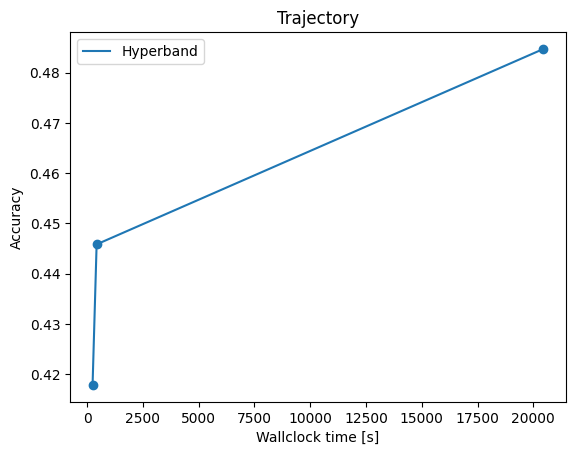

Timer unit: 1e-09 s

Total time: 40145.3 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_79690/362378926.py
Function: main at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def main():
     4         1     173000.0 173000.0      0.0      RF = RFWrapper()
     5                                           
     6         1       1000.0   1000.0      0.0      facades: list[AbstractFacade] = []
     7         2      36000.0  18000.0      0.0      for intensifier_object in [Hyperband]:
     8                                           
     9         2      23000.0  11500.0      0.0          scenario = Scenario(
    10         1     783000.0 783000.0      0.0              RF.configspace,
    11         1          0.0      0.0      0.0              walltime_limit = 1800,
    12         1      37000.0  37000.0      0.0              output_directory=Path("smac_hyperband_output_budget_30mins_RF"),
    13  

In [107]:
from line_profiler import LineProfiler
from pathlib import Path
def main():
    RF = RFWrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:

        scenario = Scenario(
            RF.configspace,
            walltime_limit = 1800,
            output_directory=Path("smac_hyperband_output_budget_30mins_RF"),
            n_trials=10000,
            min_budget=100,
            max_budget=1000,
            n_workers=8,

        )

        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")

        smac = MFFacade(
            scenario,
            RF.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )

        print("optimiizing")
        print(type(smac), "|", smac)
        incumbent = smac.optimize()
        print("incumbent:", incumbent)
        default_cost = smac.validate(RF.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")

        facades.append(smac)
        for arrt in dir(smac):
            if not arrt.startswith("_"):
                print(arrt, getattr(smac, arrt))

    print("facades:", facades)
    BO_file = None
    plot_trajectory(facades, BO_file)


if __name__ == "__main__":
    # with open('smac_results_2h.txt', "w") as f:
    #     pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

    

In [92]:
cnn32 = SimpleCNN32Filter(num_classes=18)
cnn32_2l = SimpleCNN32Filter2Layers(num_classes=18)
cnn32_5l = SimpleCNN32Filter5Layers(num_classes=18)
class CNN32Wrapper(BaseEstimator):
    def __init__(self, criterion = nn.CrossEntropyLoss()):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = cnn32_2l.to(self.device)
        self.criterion = criterion
        self.lr = None
        self.batch_size = None
        self.epochs = None
        self.optimizer = None


    @property
    def configspace(self) -> ConfigurationSpace:
        cs = ConfigurationSpace()
        lr_init = Float("lr_init", (0.001, 0.1), log=True)
        learning_rate = Categorical("learning_rate", ["constant", "invscaling", "adaptive"], default="constant")
        solver = Categorical("solver", ["sgd", "adam"])
        batch_size = Integer("batch_size", (32, 1024))
        epochs = Integer("epochs", (30, 120))
        cs.add_hyperparameters([lr_init, learning_rate, solver, batch_size, epochs])

        use_lr = EqualsCondition(child=learning_rate, parent=solver, value="sgd")
        cs.add_conditions([use_lr])

        weight_decay = Float("weight_decay", (0.0001, 0.1), log=True)
        momentum = Float("momentum", (0, 0.99))
        dampening = Float("dampening", (0, 0.99))
        cs.add_hyperparameters([weight_decay, momentum, dampening])

        weight_decay_condition = InCondition(child=weight_decay, parent=solver, values=["sgd", "adam"])
        momentum_condition = InCondition(child=momentum, parent=solver, values=["sgd"])
        dampening_condition = InCondition(child=dampening, parent=solver, values=["sgd"])
        cs.add_conditions([use_lr, weight_decay_condition, momentum_condition, dampening_condition])

        return cs

    def fit(self, config: Configuration, seed: int = 0, budget: int = 250) -> float: 
        self.trial_start_time = time.perf_counter()

        print("Config:", config)
        # print(time.time())
        epoch_start_timer = time.perf_counter()
        # print("okay here?")
        max_epochs = [0]
        # print("what abt here?")

        X = train_x.reshape(-1, 1, 32, 32)
        y = train_y
        valid_x_inFit = valid_x.reshape(-1, 1, 32, 32)

        ### only for resnet:
        # X = X.repeat(1, 3, 1, 1)
        # valid_x_inFit = valid_x_inFit.repeat(1, 3, 1, 1)


        # print("so far so good")
        print("Model:", self.model)
        model = self.model
        # print("break1")
        print("Criterion:", self.criterion)
        criterion = self.criterion

        self.lr = config.get('lr_init')
        # print("lr:", self.lr)
        self.epochs = config.get('epochs')
        # print("epochs:", self.epochs)
        self.batch_size = config.get('batch_size')
        # print("batch_size:", self.batch_size)
        # print("solver type:", type(self.sovler))
        solver_name = config.get('solver')
        # print("solver_name:", solver_name, type(solver_name))
        momentum = config.get('momentum', 0)
        weight_decay = config.get('weight_decay', 0)
        dampening = config.get('dampening', 0)
        print("is sgd:", solver_name=='sgd', "| is adam:", solver_name=='adam')
        print(self.model.parameters())
        if solver_name == 'sgd':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'momentum': config.get('momentum', 0),
            #     'weight_decay': config.get('weight_decay', 0),
            #     'dampening': config.get('dampening', 0)
            # }
            self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=momentum, weight_decay=weight_decay, dampening=dampening)

        elif solver_name == 'adam':
            # optimizer_args = {
            #     'lr': self.lr,
            #     'weight_decay': config.get('weight_decay', 0) 
            # }
            self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=weight_decay)

        else:
            raise ValueError(f"Unknown optimizer: {solver_name}")
        # print("solver type:", type(self.optimizer))
        # print("solver:", self.optimizer)
        prev_loss = float("inf")
        flag = 0

        for epoch in range(self.epochs):
            model.train()
            for i in range(0, len(X), self.batch_size):
                inputs = X[i : i + self.batch_size].to(self.device)
                labels = y[i : i + self.batch_size].to(self.device)
                self.optimizer.zero_grad()
                if inputs.shape[0] <= 2:
                    continue
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

            model.eval()
            cur_loss = 0
            with torch.no_grad():
                for i in range(0, len(valid_x_inFit), self.batch_size):
                    # get the inputs
                    inputs = valid_x_inFit[i : i + self.batch_size].to(self.device)
                    labels = valid_y[i : i + self.batch_size].to(self.device)
                    if inputs.shape[0] == 1:
                        inputs = torch.cat((inputs, inputs, inputs), dim = 0)
                        labels = torch.cat((labels, labels, labels), dim = 0)

                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    cur_loss += loss
            # early stop if 3 epochs in a row no loss decrease
            # print(round(time.time()-epoch_start_timer, 2))
            # if time.perf_counter() - epoch_start_timer > budget:
            #     print(f"Stopping training early at epoch {epoch} due to time budget.")
            #     break  # Stop training if budget exceeded
            
            if cur_loss < prev_loss:
                prev_loss = cur_loss
                flag = 0
            else:
                flag += 1
                if flag >= 3:
                    max_epochs.append(epoch)
                    break

        # print(np.max(max_epochs))
        print("evaluating...")
        model.eval()
        with torch.no_grad():
            outputs = model(valid_x_inFit.to(self.device))
            _, predicted = torch.max(outputs.data, 1)
            predictions = predicted.cpu().numpy()
        acc = accuracy_score(valid_y, predictions)
        print("accuracy:", acc)

        self.trial_end_time = time.perf_counter()
        valid_probs = self.predict_proba(valid_x_inFit)
        valid_kappa = cohen_kappa_score(valid_y, predictions)
        valid_ece = get_ece(valid_probs, predictions, valid_y)
        with open('smac_results_2h.txt', "a") as f:
            f.write(f"Valid Accuracy: {acc}, Valid Kappa: {valid_kappa}, Valid ECE: {valid_ece}, Time: {self.trial_end_time - self.trial_start_time}\n")
            
        return 1-acc
    
    def predict_proba(self, X):
        # X = X.reshape(-1, 1, 32, 32)
        model = self.model
        model.eval()
        test_probs = []
        with torch.no_grad():
            outputs = model(X.to(self.device))
            test_prob = nn.Softmax(dim=1)(outputs)
            test_probs = test_prob.cpu().numpy()
            return test_probs

def plot_trajectory(facades: list[AbstractFacade], BO_file = None) -> None:
    """Plots the trajectory (incumbents) of the optimization process."""
    plt.figure()
    plt.title("Trajectory")
    plt.xlabel("Wallclock time [s]")
    # print(len(facades))
    plt.ylabel("Accuracy")
    print("\nfacades[0]:", facades[0].scenario)
    # print("\nfacades[1]:", facades[1].scenario)
    # plt.ylim(0, 0.4)

    for facade in facades:
        X, Y = [], []
        for item in facade.intensifier.trajectory:
            # Single-objective optimization
            assert len(item.config_ids) == 1
            assert len(item.costs) == 1
            # print(1 - round(item.costs[0], 3))
            y = item.costs[0]
            x = item.walltime
            print(type(item.costs[0]), item.costs[0])
            X.append(x)
            Y.append(1-y)

        plt.plot(X, Y, label=facade.intensifier.__class__.__name__)
        plt.scatter(X, Y, marker="o")

    if BO_file:
        with open(BO_file, "r") as f:
            data = f.readlines()
        bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

        # Parse the data
        for line in data:
            # Using regular expression to find all the floating point numbers in each line
            if "Time: " in line:
                numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                if numbers:
                    bo_accuracy.append(float(numbers[0]))
                    bo_kappa.append(float(numbers[1]))
                    bo_ece.append(float(numbers[2]))
                    bo_time.append(float(numbers[3]))

        max_bo_accs = np.maximum.accumulate(bo_accuracy)
        bo_cum_time = np.cumsum(bo_time)
        plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')
    

    plt.legend()
    plt.show()


[INFO][abstract_initial_design.py:82] Using `n_configs` and ignoring `n_configs_per_hyperparameter`.
[INFO][abstract_initial_design.py:147] Using 5 initial design configurations and 0 additional configurations.
optimizing...
<class 'smac.facade.multi_fidelity_facade.MultiFidelityFacade'> | <smac.facade.multi_fidelity_facade.MultiFidelityFacade object at 0x7fd0a8289790>
[INFO][successive_halving.py:164] Successive Halving uses budget type BUDGETS with eta 3, min budget 100, and max budget 1000.
[INFO][successive_halving.py:323] Number of configs in stage:
[INFO][successive_halving.py:325] --- Bracket 0: [9, 3, 1]
[INFO][successive_halving.py:325] --- Bracket 1: [5, 1]
[INFO][successive_halving.py:325] --- Bracket 2: [3]
[INFO][successive_halving.py:327] Budgets in stage:
[INFO][successive_halving.py:329] --- Bracket 0: [111.1111111111111, 333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 1: [333.3333333333333, 1000.0]
[INFO][successive_halving.py:329] --- Bracket 

2024-03-18 03:08:15,742 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 03:08:15,745 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 03:08:15,746 - distributed.core - INFO - Event loop was unresponsive in Nanny for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 03:08:15,754 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 4.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 03:08:15,764 - distributed.core - INFO - Even

evaluating...
accuracy: 0.38110539845758357
Config: Configuration(values={
  'batch_size': 364,
  'epochs': 42,
  'lr_init': 0.003443828204410421,
  'solver': 'adam',
  'weight_decay': 0.006816528882124754,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f8170f13970>
evaluating...
accuracy: 0.37146529562982006
Config: Configuration(values={
  'batch_size': 920,
  'epochs': 37,
  'lr_init': 0.003028804472702814,
  'solver': 'adam',
  'weight_decay': 0.008333167672620306,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4

2024-03-18 04:45:38,006 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:45:38,101 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:45:38,135 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:45:38,148 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:45:38,154 - distributed.core - INFO - Event loop w

Config: Configuration(values={
  'batch_size': 284,
  'epochs': 30,
  'lr_init': 0.0031260298013969716,
  'solver': 'adam',
  'weight_decay': 0.019684954672470723,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7f9de09bc5f0>
evaluating...
accuracy: 0.33740359897172234
[INFO][smbo.py:319] Finished 600 trials.
Config: Configuration(values={
  'batch_size': 479,
  'epochs': 32,
  'lr_init': 0.0043021467355769324,
  'solver': 'adam',
  'weight_decay': 0.0006429430276907404,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4

2024-03-18 04:56:20,106 - distributed.core - INFO - Event loop was unresponsive in Nanny for 3.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:56:20,121 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:56:20,134 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:56:20,167 - distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-03-18 04:56:20,172 - distributed.core - INFO - Even

Config: Configuration(values={
  'batch_size': 284,
  'epochs': 49,
  'lr_init': 0.0031260298013969716,
  'solver': 'adam',
  'weight_decay': 0.019674872931122127,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4608, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=18, bias=True)
)
Criterion: CrossEntropyLoss()
is sgd: False | is adam: True
<generator object Module.parameters at 0x7fb909167820>
evaluating...
accuracy: 0.13110539845758354
evaluating...
accuracy: 0.18766066838046272
Config: Configuration(values={
  'batch_size': 371,
  'epochs': 96,
  'lr_init': 0.026020728726248003,
  'solver': 'adam',
  'weight_decay': 0.00508546599777014,
})

Model: SimpleCNN32Filter2Layers(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=4

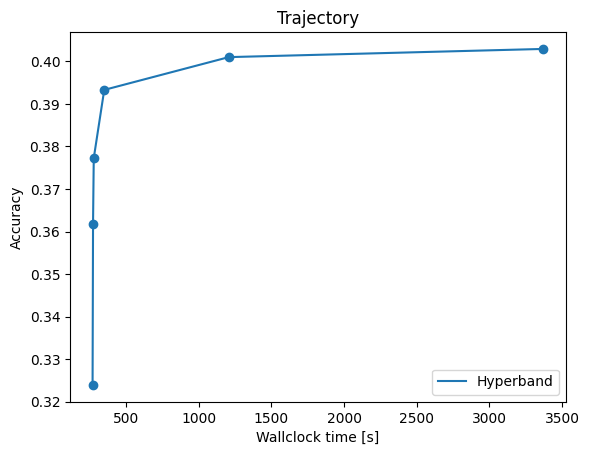

Timer unit: 1e-09 s

Total time: 7601.03 s
File: /var/folders/w0/pq4q2kj50fvdt6t_4y4gqfvw0000gn/T/ipykernel_79690/3878607375.py
Function: main at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def main():
     2                                           
     3                                               
     4         1     888000.0 888000.0      0.0      CNN32 = CNN32Wrapper()
     5                                           
     6         1          0.0      0.0      0.0      facades: list[AbstractFacade] = []
     7         2      11000.0   5500.0      0.0      for intensifier_object in [Hyperband]:
     8                                                   # Define our environment variables
     9                                                   
    10         2      72000.0  36000.0      0.0          scenario = Scenario(
    11         1    2998000.0    3e+06      0.0              CNN32.configspace,
    

2024-03-18 08:05:37,793 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:57825'. Reason: nanny-close
2024-03-18 08:05:37,794 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2024-03-18 08:05:37,797 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:57826'. Reason: nanny-close
2024-03-18 08:05:37,798 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2024-03-18 08:05:37,799 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:57827'. Reason: nanny-close
2024-03-18 08:05:37,799 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2024-03-18 08:05:37,800 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:57828'. Reason: nanny-close
2024-03-18 08:05:37,801 - distributed.nanny - INFO - Nanny asking worker to close. Reason: nanny-close
2024-03-18 08:05:37,802 - distributed.nanny - INFO - Closing Nanny at 'tcp://127.0.0.1:57829'. Reason: nanny-close
2024-03-18 08

In [94]:

def main():

    
    CNN32 = CNN32Wrapper()

    facades: list[AbstractFacade] = []
    for intensifier_object in [Hyperband]:
        # Define our environment variables
        
        scenario = Scenario(
            CNN32.configspace,
            walltime_limit=7200,  # After 3600 seconds, we stop the hyperparameter optimization
            output_directory=Path("smac_hyperband_output_budget_2hr_CNN_2l"),
            n_trials=10000,  # Evaluate max 500 different trials
            min_budget=100,  # Train the MLP using a hyperparameter configuration for at least 5 epochs
            # max_budget=25,  # Train the MLP using a hyperparameter configuration for at most 25 epochs
            max_budget=1000,  # only for CNN32_5layers, Resnet18
            n_workers=8,
        )


        
        # We want to run five random configurations before starting the optimization.
        initial_design = MFFacade.get_initial_design(scenario, n_configs=5)
        
        # Create our intensifier
        intensifier = intensifier_object(scenario, incumbent_selection="highest_budget")
        
        # print("Holy shit I'm gonna fiiiiiiiiiiiiiit")
        # Create our SMAC object and pass the scenario and the train method
        smac = MFFacade(
            scenario,
            CNN32.fit,
            initial_design=initial_design,
            intensifier=intensifier,
            overwrite=True,
        )
        # print("I fitted!!!!!!!!!!!!!!:", smac)

        # Let's optimize
        print("optimizing...")
        print(type(smac), "|", smac)
        opt_start_time = time.time()
        incumbent = smac.optimize()
        opt_end_time = time.time()
        print(f"opt execution time: {opt_end_time - opt_start_time} seconds")
        print("incumbent:", incumbent)
        # break
        # Get cost of default configuration
        default_cost = smac.validate(CNN32.configspace.get_default_configuration())
        print(f"Default cost ({intensifier.__class__.__name__}): {default_cost}")

        # Let's calculate the cost of the incumbent
        incumbent_cost = smac.validate(incumbent)
        print(f"Incumbent cost ({intensifier.__class__.__name__}): {incumbent_cost}")
        print("appending...")
        facades.append(smac)
        for attr in dir(smac):
            if not attr.startswith('__'):
                print(attr, getattr(smac, attr))
    print("attempting to plot")
    # Let's plot it
    print("facades:", facades)
    BO_file = "CNN32_5l_BO_results_2h.txt"
    plot_trajectory(facades)

if __name__ == "__main__":
    with open('smac_results_2h.txt', "w") as f:
        pass
    profiler = LineProfiler()
    profiler.add_function(main)
    profiler.enable()

    main()

    profiler.disable()
    profiler.print_stats()

20450.281787872314
0.0 68.07081246376038
16787.323990106583 92750.32793998718


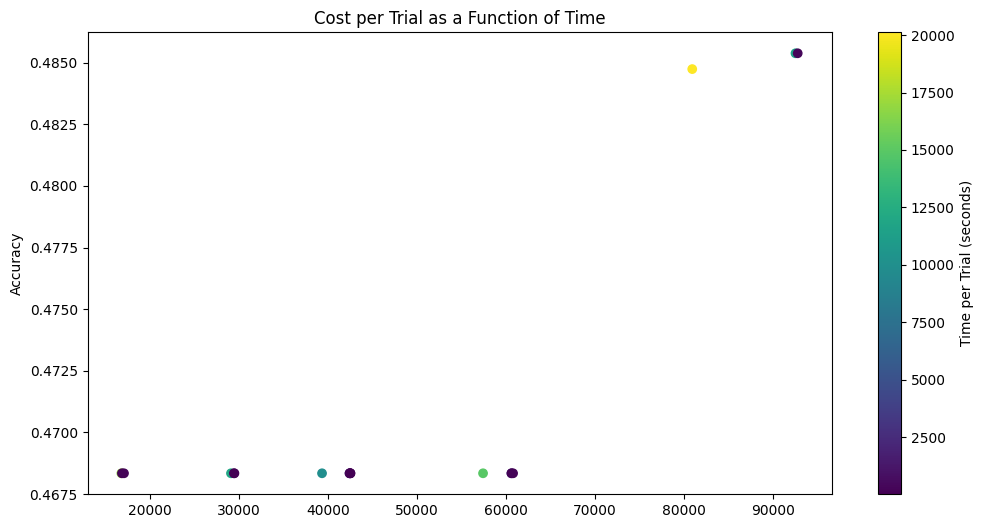

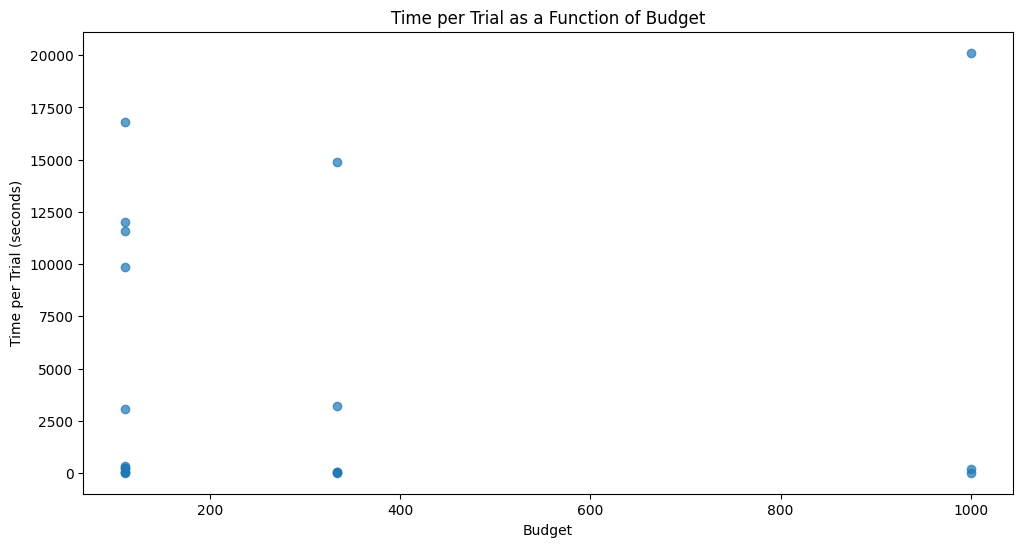

In [108]:
import json

# f = open('smac3_output\\37512afe2414205597b078349da12853\\0\\runhistory.json')
f = open('smac_hyperband_output_budget_30mins_RF/c5a674af8d209d7f6312b77492a2fbb9/0/runhistory.json')
runhistory = json.load(f)

# Reinitialize lists for plotting with corrected parsing
trial_times = []  # Start times for each trial
trial_accuracies = []  # Inverted costs for accuracy
trial_durations = []  # Duration of each trial
trial_budgets = []  # Budgets for each trial

# Parse the corrected structure of runhistory
for entry in runhistory['data']:
    # Extracting elements from each entry
    _, _, _, budget, cost, duration, _, start_time, _, _ = entry
    
    # Invert cost to get accuracy
    accuracy = cost
    
    trial_times.append(start_time)
    trial_accuracies.append(accuracy)
    trial_durations.append(duration)
    trial_budgets.append(budget)

# Sort trials by start time for sequential plotting
sorted_indices = sorted(range(len(trial_times)), key=lambda k: trial_times[k])
sorted_accuracies = [trial_accuracies[i] for i in sorted_indices]
sorted_durations = [trial_durations[i] for i in sorted_indices]
sorted_budgets = [trial_budgets[i] for i in sorted_indices]

# Plot Accuracy per Trial as a Function of Time
plt.figure(figsize=(12, 6))
# plt.scatter(range(len(sorted_accuracies)), sorted_accuracies, c=sorted_durations, cmap='viridis')

# Convert absolute timestamps to relative times (with the first trial starting at time 0)
relative_start_times = [time - trial_times[sorted_indices[0]] for time in trial_times]
sorted_relative_start_times = [relative_start_times[i] for i in sorted_indices]

# Calculate cumulative relative times
cumulative_relative_times = [sorted_relative_start_times[0]]  # Start with the first trial's relative start time
for i in range(1, len(sorted_relative_start_times)):
    # The cumulative time at each trial is the max of the previous cumulative time or the current trial's start time
    # plus the current trial's duration to include the trial's full time span
    cumulative_relative_times.append(max(cumulative_relative_times[i-1], sorted_relative_start_times[i] + sorted_durations[i]))

peak_accuracies = []
# Initialize the first peak accuracy as the first trial's accuracy
current_peak = sorted_accuracies[0]
peak_accuracies.append(current_peak)


# Iterate through the sorted accuracies to find the peak accuracy at each trial
for acc in sorted_accuracies[1:]:
    # Update the current peak if the current trial's accuracy is higher
    current_peak = min(current_peak, acc)
    peak_accuracies.append(current_peak)

acc_list = []
for i in peak_accuracies:
    acc_list.append(1-i)

dur_cumsum = np.cumsum(sorted_durations)
print(cumulative_relative_times[-1])
plt.scatter(dur_cumsum, acc_list, c=sorted_durations, cmap='viridis') #cumulative_relative_times
# plt.plot(cumulative_relative_times, peak_accuracies)#, c=sorted_durations, cmap='viridis') #cumulative_relative_times
print(cumulative_relative_times[0], cumulative_relative_times[1])
print(dur_cumsum[0], dur_cumsum[-1])

plt.colorbar(label='Time per Trial (seconds)')
# plt.xlabel('Trial Index')
plt.ylabel('Accuracy')
plt.title('Cost per Trial as a Function of Time')
plt.show()

# Plot Time per Trial as a Function of Budget
plt.figure(figsize=(12, 6))
plt.scatter(sorted_budgets, sorted_durations, alpha=0.7)
plt.xlabel('Budget')
plt.ylabel('Time per Trial (seconds)')
plt.title('Time per Trial as a Function of Budget')
plt.show()

In [ ]:
runhistory_path = "smac_hyperband_output_budget_2hr_CNN_2l/981016df88b4a1e60e7a6ea6af063c5f/0/runhistory.json"

with open(runhistory_path, "r") as file:
    runhistory_data = json.load(file)

configs_costs = []
for entry in runhistory_data["data"]:
    config_id = entry[0]  
    cost = entry[4]  
    configs_costs.append((entry[0], entry[4]))
    # print(f"Config ID: {config_id}, Cost: {cost}")

min_cost_config = min(configs_costs, key=lambda x: x[1])
min_cost_config_id, min_cost = min_cost_config

print(f"min id:{min_cost_config_id}, min cost:{min_cost}")

min_cost_params = runhistory_data["configs"][str(min_cost_config_id)]
print(min_cost_params)

In [36]:
# with open("CNN32_5l_BO_results_2h.txt", "r") as f:
#     data = f.readlines()
# bo_accuracy, bo_kappa, bo_ece, bo_time = [], [], [], []

# # Parse the data
# for line in data:
#     # Using regular expression to find all the floating point numbers in each line
#     if "Time: " in line:
#         numbers = re.findall(r"[-+]?\d*\.\d+|\d+", line)
#         if numbers:
#             bo_accuracy.append(float(numbers[0]))
#             bo_kappa.append(float(numbers[1]))
#             bo_ece.append(float(numbers[2]))
#             bo_time.append(float(numbers[3]))

# max_bo_accs = np.maximum.accumulate(bo_accuracy)
# bo_cum_time = np.cumsum(bo_time)
# plt.plot(bo_cum_time, max_bo_accs, label='Max BO Accuracies', marker='x')


# plt.legend()

{111.1111111111111: 158.72248113856597, 333.3333333333333: 340.8047302246094, 1000.0: 334.5399566491445}


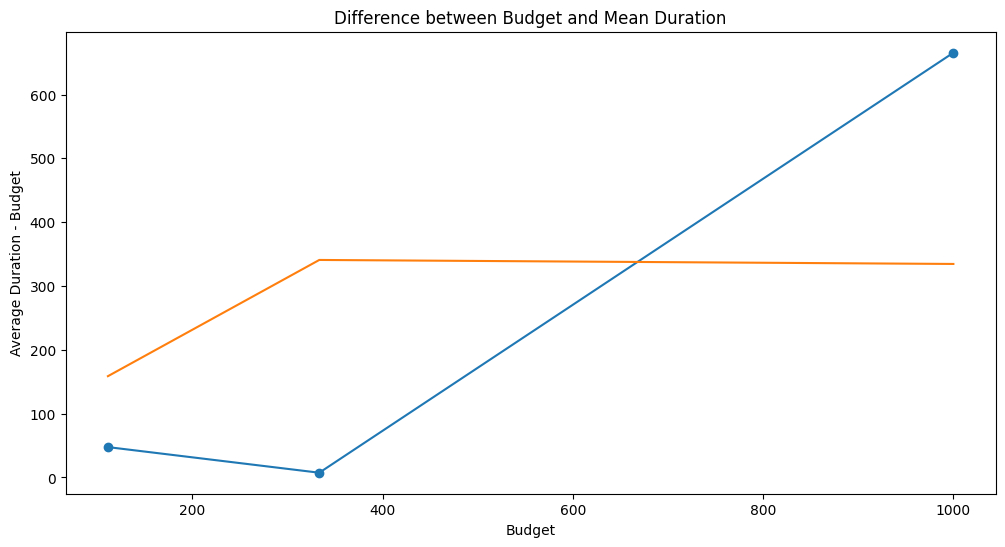

In [48]:
f = open('smac_hyperband_output_budget_test_CNN_5l/aa5f08a8aba13f3c073649795dec751e/0/runhistory.json')
runhistory = json.load(f)
budget_duration_pairs = zip(sorted_budgets, sorted_durations)
budget_durations_dict = {}
for budget, duration in budget_duration_pairs:
    if budget not in budget_durations_dict:
        budget_durations_dict[budget] = []
    budget_durations_dict[budget].append(duration)

# average_durations = {budget: np.mean(durations) for budget, durations in budget_durations_dict.items()}
average_durations = {}
for budget, durations in budget_durations_dict.items():
    mean_duration = np.mean(durations)
    average_durations[budget] = mean_duration

print(average_durations)

difference = {budget: abs(durations - budget) for budget, durations in average_durations.items()}

budgets = list(difference.keys())
means = list(average_durations.values())
diffs = list(difference.values())

plt.figure(figsize=(12, 6))
plt.title('Difference between Budget and Mean Duration')
plt.xlabel('Budget')
plt.ylabel('Average Duration - Budget')
plt.plot(budgets, diffs)
plt.plot(budgets, means)
plt.scatter(budgets, diffs, alpha=1)
plt.show()


In [118]:
budget_list = []
sum_diff_dict = {}

In [156]:

for budget, diff in difference.items():
    if budget not in budget_list:
        budget_list.append(budget)
        sum_diff_dict[budget] = diff

print(budget_list)
print(sum_diff_dict)


[2.7777777777777777, 8.333333333333332, 25.0, 50.0, 100.0, 200.0]
{2.7777777777777777: 56.94472012696443, 8.333333333333332: 49.530394270306545, 25.0: 32.74412428855896, 50.0: 45.56316891694681, 100.0: 39.17683368816711, 200.0: 34.80959320790839}


{2.7777777777777777: 59.722497904742205, 8.333333333333332: 57.86372760363987, 25.0: 57.74412428855896, 50.0: 95.56316891694681, 100.0: 139.1768336881671, 200.0: 234.8095932079084}
{2.7777777777777777: 56.94472012696443, 8.333333333333332: 49.530394270306545, 25.0: 32.74412428855896, 50.0: 45.56316891694681, 100.0: 39.17683368816711, 200.0: 34.80959320790839}


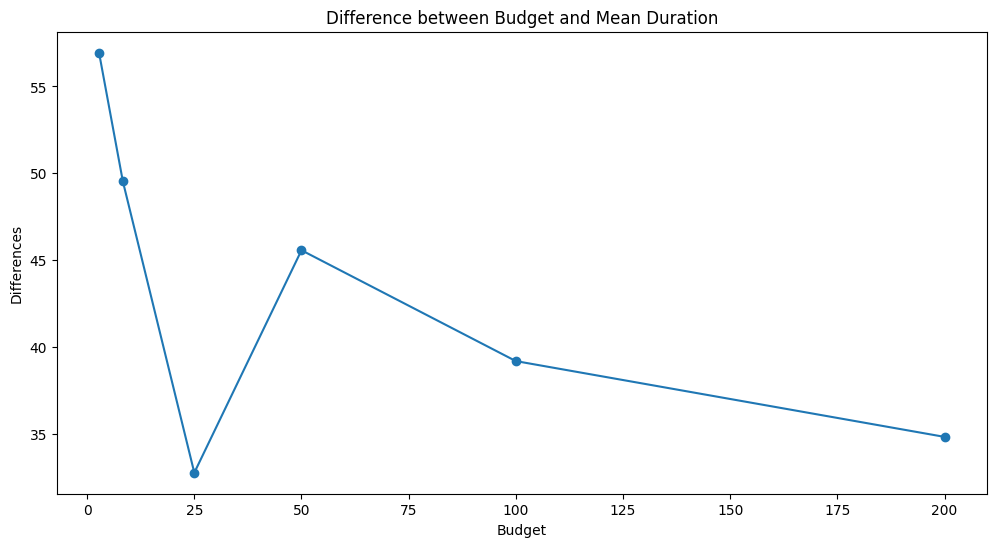

In [164]:
means = {}
for budget, diff in sum_diff_dict.items():

    means[budget] = diff+budget
print(means)

x = []
y = []
z = []
for budget, diff in sum_diff_dict.items():
    x.append(budget)
    y.append(diff)

# for budget, diff in means.items():
#     n.append(diff)
print(sum_diff_dict)
plt.figure(figsize=(12, 6))
plt.title('Difference between Budget and Mean Duration')
plt.xlabel('Budget')
plt.ylabel('Differences')
plt.plot(x, y)
plt.scatter(x, y, alpha=1)
# plt.plot(x, z)
# plt.scatter(x, z, alpha=1)
plt.show()

In [115]:
runhistory_path = "smac_hyperband_output_budget_2hr_RF/runhistory.json"

with open(runhistory_path, "r") as file:
    runhistory_data = json.load(file)

configs_costs = []
for entry in runhistory_data["data"]:
    config_id = entry[0]  
    cost = entry[4]  
    configs_costs.append((entry[0], entry[4]))
    # print(f"Config ID: {config_id}, Cost: {cost}")

min_cost_config = sorted(configs_costs, key=lambda x: x[1])[:5]
for config_id, cost in min_cost_config:
    
    params = runhistory_data["configs"][str(config_id)]
    print(f"Config ID: {config_id}, Cost: {cost}, Parameters: {params}\n")

# min_cost_config = min(configs_costs, key=lambda x: x[1])
# min_cost_config_id, min_cost = min_cost_config

# print(f"min id:{min_cost_config_id}, min cost:{min_cost}")

# min_cost_params = runhistory_data["configs"][str(min_cost_config_id)]
# print(min_cost_params)

Config ID: 341, Cost: 0.5376432559506318, Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 332}

Config ID: 341, Cost: 0.5376432559506318, Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 332}

Config ID: 341, Cost: 0.5376432559506318, Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 332}

Config ID: 411, Cost: 0.5376432559506318, Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 336}

Config ID: 413, Cost: 0.5376432559506318, Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 338}

